In [2]:
import sys

#sys.path.append("/mnt/hvae/")
#sys.path.append("/mnt/mei/")

device = "cpu"

In [15]:
import torch
from src.checkpoint import Checkpoint

experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-09-23__16-22/migrated_checkpoint.pth")
model = experiment.get_model().to(device)

In [13]:
for m in model.encoder.blocks["hiddens"].children():
    print(m.__class__)

<class 'src.utils.SerializableSequential'>


In [14]:
from src.hvae.model import compute_loss

target_block = "y"

elbo_scaler = 1
tv_scaler = 0
use_mean = False

from meitorch.objective.objective_reguralization import tv_norm

def operation_target(x):
    computed, distributions = model(x, use_mean=True)
    return computed[target_block]

def operation(target_unit):
    def op(x):
        tv = tv_norm(x)[0]
        tv *= tv_scaler
        computed, distributions = model(x, use_mean=use_mean)
        losses = compute_loss(x, distributions)
        target = computed[target_block]
        to_query = torch.flatten(target, start_dim=1)
        elbo = losses["loss"] * elbo_scaler
        to_add = elbo + tv
        activation = torch.mean(to_query[:, target_unit], dim=0)
        loss = -activation + to_add
        
        clone = to_query.clone()
        clone[:, target_unit] = 0
        max_acts, _ = torch.max(clone, dim=1)
        mean_max_act = torch.mean(max_acts)
        
        results = dict(
            objective=loss,
            activation=activation,
        )
        if tv_scaler > 0:
            results.update({"tv": tv})
        results.update({"elbo": elbo})
        results.update({"max_activation":mean_max_act})
        
        return results
    return op

def operation_family_mean(family_mean):
    def op(x):
        tv = tv_norm(x)[0] 
        computed, distributions = model(x, use_mean=False)
        losses = compute_loss(x, distributions)
        target = computed[target_block]
        to_add = losses["kl_div"] * kl_scaler + tv * tv_scaler
        family = torch.tensor(family_mean, device=device)
        loss_fn = torch.nn.MSELoss()
        activation = loss_fn(target, family)
        loss = activation + to_add
        
        return dict(
            kl=to_add,
            objective=loss,
            activation=activation
        )
    return op


In [4]:
from meitorch.mei import MEI
from meitorch.tools.schedules import LinearSchedule, OctaveSchedule, Scheduler, ConstantSchedule

texture_dims = [91, 86, 110, 11, 225]
non_texture_dims = [214, 163, 223, 10, 219]

In [5]:
from matplotlib.pyplot import figure, savefig
import numpy as np

#receptive_fields = white_noise_analysis(operation=operation_target, shape=(1, 40, 40), n_samples=1_000_000, sigma=0.1, device=device)

def plot_wna(units, save=None):
    fig = figure(figsize=(10, 3))
    for n, i in enumerate(units):
        ax = fig.add_subplot(1, 5, n + 1)
        ax.imshow(receptive_fields[i, ...].reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_wna(texture_dims, save="y_textutre_decoding_wna.png")
#plot_wna(non_texture_dims, save="y_non_textutre_encoding_wna.png")
#np.save("y_receptive_fields_1m.npy", receptive_fields)

In [6]:
from matplotlib.pyplot import figure, savefig, suptitle
import numpy as np

def plot_meis(meis, save=None, fig_title=""):
    fig = figure(figsize=(12, 6))
    for n, mei in enumerate(meis):
        ax = fig.add_subplot(2, 5, n + 1)
        image = mei.get_image()[0].detach().cpu().numpy()
        ax.imshow(image.reshape(40, 40))
        ax.set_title(f"Activation: {mei.get_activation():.2f}")
        ax.axis("off")
    suptitle(fig_title)
    if save:
        savefig(save)
        
        
def get_title_for(mode, config):
    if mode == "image":
        title = f"""Image Based MEI
                 iter_n: {config['iter_n']} | optimizer: {config['optimizer']} | lr: {config['optimizer_params']['lr']}| """
        if elbo_scaler > 0:
            title += f"elbo: {elbo_scaler} | "
        if tv_scaler > 0:
            title += f"tv: {tv_scaler} | "
        for hparam in ["scaler", "jitter", "train_norm", "norm", "precond", "blur"]:
            if config[hparam] is not None:
                value = str(config[hparam](1)) if callable(config[hparam]) else config[hparam]
                title += f"{hparam}: {value} | "
        title += f"use_mean: {use_mean}"
        return title
        
    elif mode == "distribution":
        title = f"""Distribution Based MEI
                    distribution: {config['distribution']} | n_samples: {config['n_samples_per_batch']} | fixed_stddev: {config['fixed_stddev']} 
                 iter_n: {config['iter_n']} | optimizer: {config['optimizer']} | lr: {config['optimizer_params']['lr']}| """
        if elbo_scaler > 0:
            title += f"elbo: {elbo_scaler} | "
        if tv_scaler > 0:
            title += f"tv: {tv_scaler} | "
        for hparam in ["scaler", "jitter", "train_norm", "precond"]:
            if config[hparam] is not None:
                value = str(config[hparam](1)) if callable(config[hparam]) else config[hparam]
                title += f"{hparam}: {value} | "
        title += f"use_mean: {use_mean}"
        return title
    elif mode == "nn":
        title = f"""NN Based MEI
                    distribution: {config['net'].distribution_base} | n_samples: {config['n_samples']} | fixed_stddev: {config['net'].fixed_stddev} | hiddens: {config['net'].hidden_sizes} | kernel_size: {config['net'].kernel_size}
                 iter_n: {config['iter_n']} | optimizer: {config['optimizer']} | lr: {config['optimizer_params']['lr']}| """
        if elbo_scaler > 0:
            title += f"elbo: {elbo_scaler} | "
        if tv_scaler > 0:
            title += f"tv: {tv_scaler} | "
        for hparam in ["scaler", "jitter", "train_norm", "precond"]:
            if config[hparam] is not None:
                value = str(config[hparam](1)) if callable(config[hparam]) else config[hparam]
                title += f"{hparam}: {value} | "
        title += f"use_mean: {use_mean}"
        return title
        


In [7]:
from meitorch.tools.schedules import RandomSchedule

In [11]:
def run_image_config(config, save=None):

    meis = []
    for dim in texture_dims:
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    results = []

    for mei in meis:
        results.append(mei.generate_pixel_mei(**config))

    base_filename = "image_y"
    i = 1
    import os
    while True:
        filename = f"{base_filename}_{i}.png"
        if not os.path.exists(filename):
            break
        i += 1
        
    print(i)
        
    fig_title = get_title_for("image", config)
    
    plot_meis(results, save=f"{base_filename}_{i}.png" if save else None, 
              fig_title=fig_title)
    return results

In [12]:
image_mei_config = dict(
    iter_n=150,
    n_samples=5, # number of samples per batch
    save_every=25,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(
        div_metric='correlation', 
        div_linkage='minimum', 
        div_weight=1, 
        div_mask=1
    ),

    #transformations
    scaler=None, #RandomSchedule(1, 1.025),              # scaling of the image (float or schedule)
    jitter=3,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step

    #optmizer
    optimizer="rmsprop",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125),
    ),

    #preconditioning
    precond=0.05,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    blur=None,
    blur_params=dict(
        #gaussian
        kernel_size=3,
        sigma=LinearSchedule(0.25, 0.01)
        
        #tv
        #regularization_scaler=1e-7,
        #lr=0.0001,
        #num_iters=5,
        
        #bilateral
        #kernel_size=3,
        #sigma_color=LinearSchedule(1, 0.01),
        #sigma_spatial=LinearSchedule(0.25, 0.01),
    ),
)

100%|██████████| 150/150 [00:05<00:00, 25.66it/s]


1


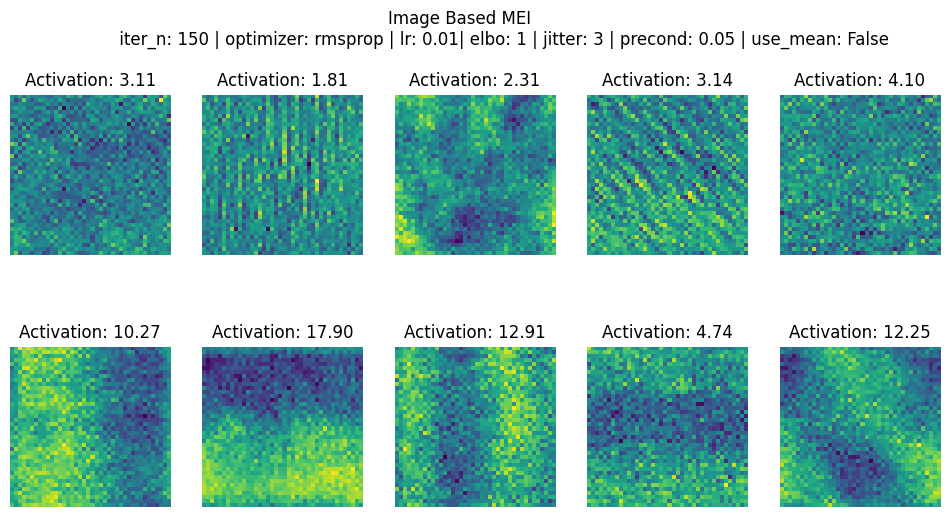

In [13]:
results = run_image_config(image_mei_config, save=True)

In [ ]:
from matplotlib.pyplot import imshow, show
for image in results[1].get_image().detach().cpu().numpy():
    imshow(image[0])
    show()
    

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
    base_filename = "image_y"
    j = 1
    import os
    while True:
        filename = f"{base_filename}_{j}.png"
        if not os.path.exists(filename):
            break
        j += 1
    
    directory = f"{base_filename}_{j}"
    os.makedirs(directory, exist_ok=True)
    results[i].plot_image_and_losses(save_path=os.path.join(directory, f"{i}.png"), ranges=(-30, 30))
pass

In [ ]:
from matplotlib.pyplot import imshow, show

for image_rmsprop in results[8].image_history:
    imshow(image_rmsprop[0][0])
    show()

In [46]:
def run_var_config(config, save=None):

    meis = []
    for dim in texture_dims:
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    results = []

    for mei in meis:
        results.append(mei.generate_variational(**config))
 
    base_filename = "var_y"
    i = 1
    import os
    while True:
        filename = f"{base_filename}_{i}.png"
        if not os.path.exists(filename):
            break
        i += 1
        
    fig_title = get_title_for("distribution", config)
    
    plot_meis(results, save=f"{base_filename}_{i}.png" if save else None, 
              fig_title=fig_title)

    return results

In [54]:
var_mei_config = dict(
    iter_n=50,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
        scheduler_params=dict(
                type="step",
                step_size=50,
                gamma=0.25
            )
        
    ),

    #preconditioning
    precond=0.5,            # strength of gradient preconditioning filter falloff (float or schedule)

    #variational
    distribution='normal',
    n_samples_per_batch=(128,),
    fixed_stddev=0.6,
)

100%|██████████| 50/50 [00:00<00:00, 89.24it/s]


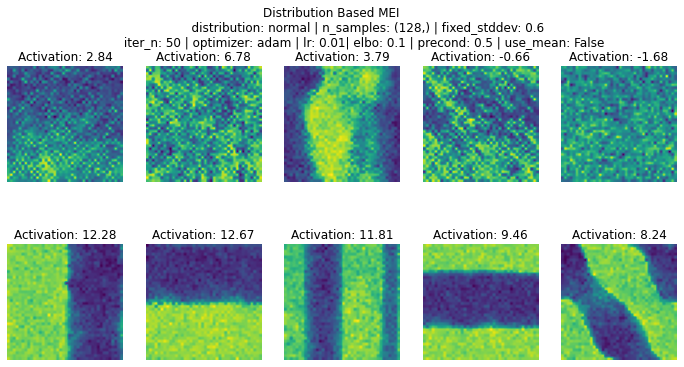

In [55]:
results = run_var_config(var_mei_config, save=True)

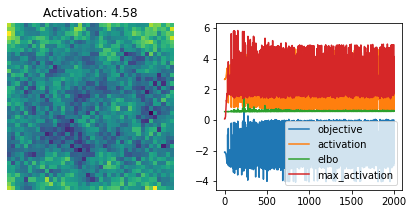

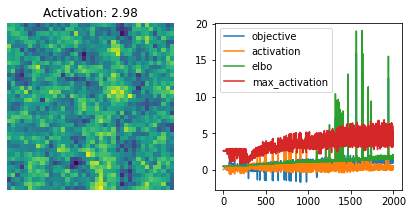

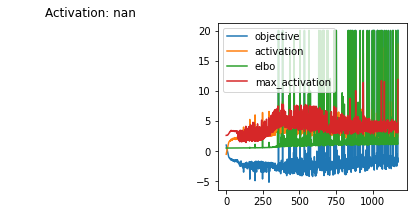

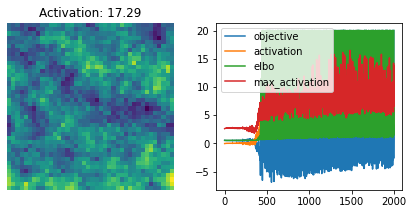

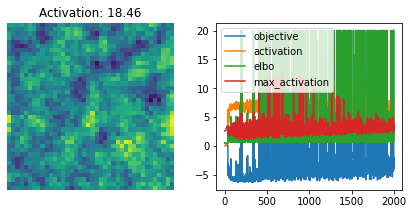

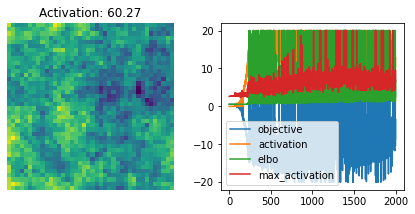

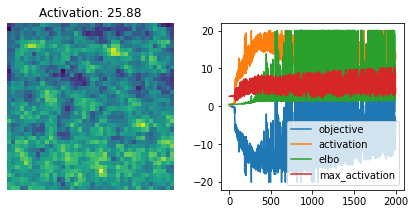

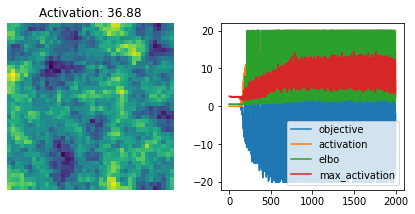

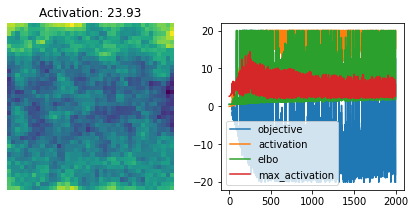

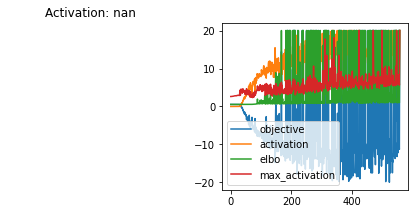

In [121]:
import matplotlib.pyplot as plt
for i in range(10):
    base_filename = "image_y"
    j = 1
    import os
    while True:
        filename = f"{base_filename}_{j}.png"
        if not os.path.exists(filename):
            break
        j += 1
    
    directory = f"{base_filename}_{j}"
    os.makedirs(directory, exist_ok=True)
    results[i].plot_image_and_losses(save_path=os.path.join(directory, f"{i}.png"), ranges=(-20, 20))
pass

In [ ]:
for sample in results[3].get_samples().detach().cpu().numpy():
    imshow(sample[0])
    show()

In [9]:
from meitorch.tools.generator_nn import GenerativeConvNet, GenerativeMLPNet, GenerativeConvNetB, AdaptiveGenerativeConvNet

class CustomGenerative(torch.nn.Module):
    
    def __init__(self, unit, activation):
        super(CustomGenerative, self).__init__()
        experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-10-07__14-17/migrated_checkpoint.pth")
        self.model = experiment.get_model().to(device)
        init = torch.zeros((1, 250), device=device)
        init[:, unit] = activation
        #init = torch.tensor(family_mean, device=device)
        self.prior = torch.nn.Parameter(init, requires_grad=True)
        for param in self.model.parameters():
            param.requires_grad = False
        #self.register_parameter("vae", model.parameters())

        
    def forward(self, batch_size, use_mean=False):
        computed = dict(y=torch.tile(self.prior, (batch_size, 1)))
        _, distributions_z = model.generator.blocks["z"].sample_from_prior(computed, 1, use_mean=True)
        z_distribution = distributions_z[0]
        computed["z"] = z_distribution.rsample()
        _, distributions_out = model.output_block.sample_from_prior(computed, 1, use_mean=True)
        output_distribution = distributions_out[0] #prior
        output = output_distribution.rsample()
        #dot = torchviz.make_dot(output)
        #dot.render("gen.png")
        return output
    

In [76]:
def run_nn_config(config, save=None):

    meis = []
    dims = []
    
    for dim in texture_dims:
        dims.append(dim)
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        dims.append(dim)
        meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    results = []
    
    for mei, dim in zip(meis, dims):
        activation = 0
        iters = 3
        while activation < 10 and iters != 0:
            conf = config(dim)
            meip = mei.generate_nn_based(**conf)
            activation = meip.get_activation()
            iters -= 1
        results.append(meip)
        
        
    base_filename = "nn_y"
    i = 1
    import os
    while True:
        filename = f"{base_filename}_{i}.png"
        if not os.path.exists(filename):
            break
        i += 1
        
    fig_title = get_title_for("nn", conf)
    
    plot_meis(results, save=f"{base_filename}_{i}.png" if save else None, 
              fig_title=fig_title)
    return results

In [95]:
def nn_mei_config(unit, activation=10):
    return dict(
        iter_n=1000,
        save_every=10,        # save image every n iterations
        bias=0,               # bias of the image
        scale=1,              # scaling of the image
        n_samples=1,

        #transformations
        scaler=None,
        jitter=None,             # size of translational jittering

        #normalization/clipping
        train_norm=None,        # norm adjustment during step

        #optmizer
        optimizer="adam",
        optimizer_params=dict(
            lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
            #step_size=LinearSchedule(2, 0.125),
            scheduler_params=dict(
                type="step",
                step_size=100,
                gamma=0.75
            )
        ),

        #preconditioning
        precond=0.4,            # strength of gradient preconditioning filter falloff (float or schedule)

        net = GenerativeConvNet([1], shape=(1, 40, 40), kernel_size=9, activate_output=False, fixed_stddev=0.6, activation=torch.nn.Tanh())
        #net = AdaptiveGenerativeConvNet([1, 2], [100], shape=(1, 40, 40), kernel_size=5, activate_output=False, fixed_stddev=0.6, device=device)
        #net = GenerativeConvNetB([1,2], shape=(1, 40, 40), kernel_size=3, activate_output=False, fixed_stddev=0.4)
        #net = GenerativeMLPNet([1600, 2000, 1600], (1, 40, 40), trainable_input=True, activate_output=False, distribution_base='normal')
        #net = CustomGenerative(unit, 20)
    )

#TODO: 
"""
-kernel size másfélék
"""

'\n-kernel size másfélék\n'

100%|██████████| 1000/1000 [00:10<00:00, 93.38it/s]


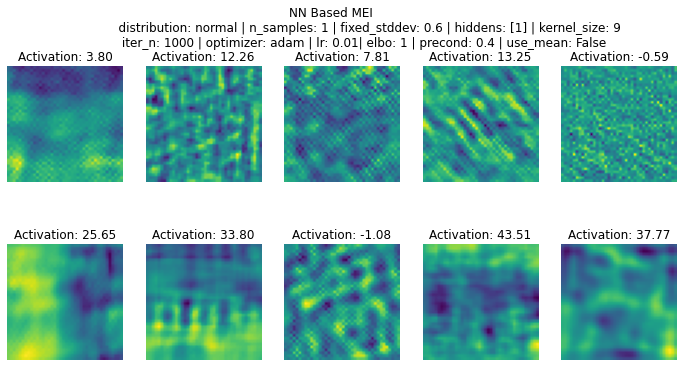

In [96]:
results = run_nn_config(nn_mei_config, save=True)

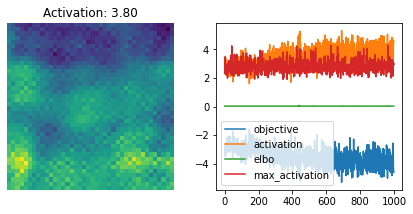

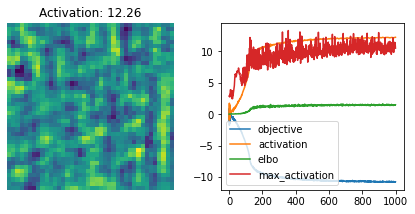

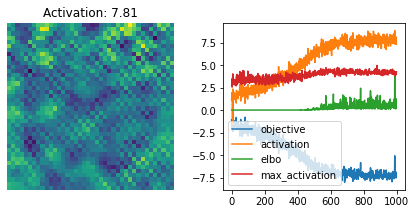

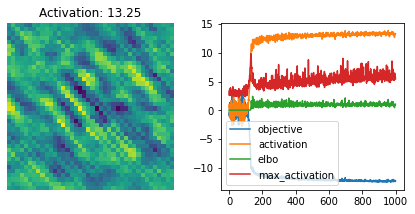

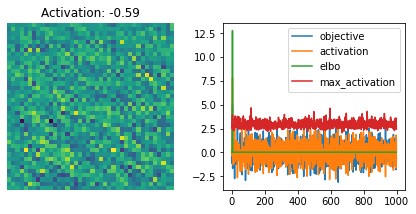

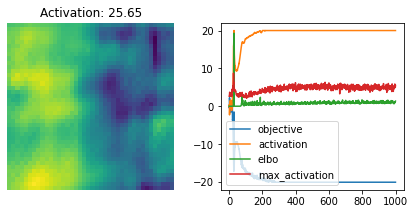

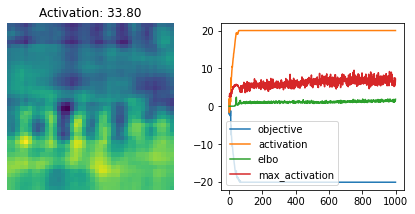

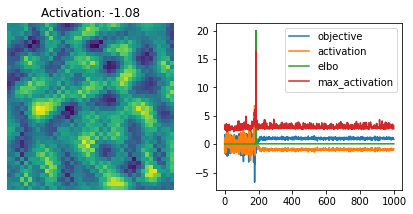

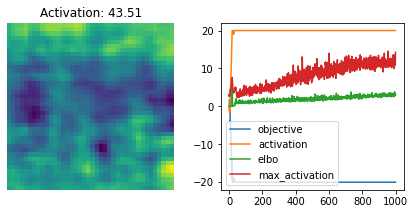

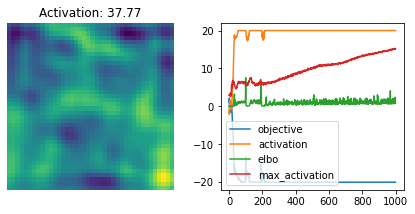

In [98]:
import matplotlib.pyplot as plt
for i in range(10):
    base_filename = "nn_y"
    j = 1
    import os
    while True:
        filename = f"{base_filename}_{j}.png"
        if not os.path.exists(filename):
            break
        j += 1
    
    directory = f"{base_filename}_{j}"
    os.makedirs(directory, exist_ok=True)
    results[i].plot_image_and_losses(save_path=os.path.join(directory, f"{i}.png"), ranges=(-20, 20))
pass

In [ ]:
print(results[1].net.)

In [307]:
family_mean = np.mean(family_act, axis=0)

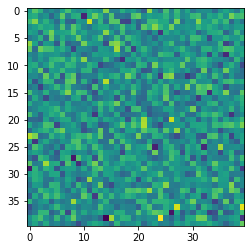

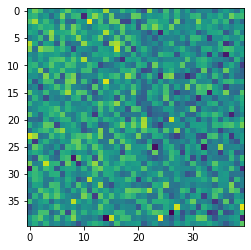

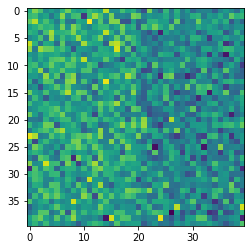

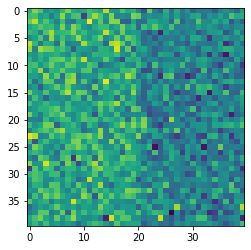

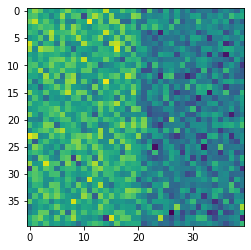

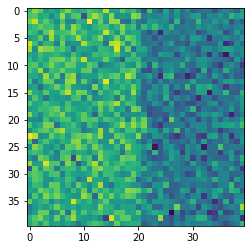

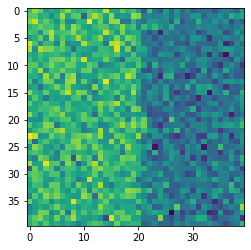

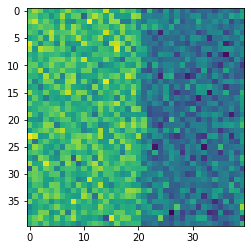

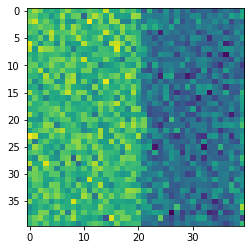

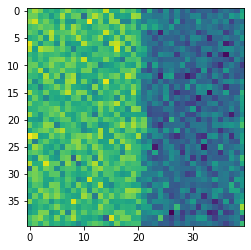

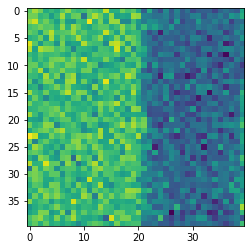

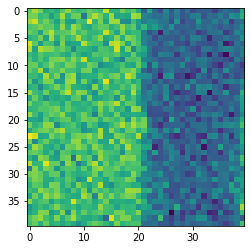

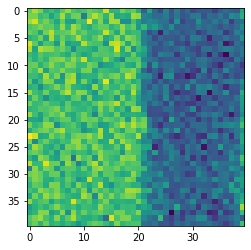

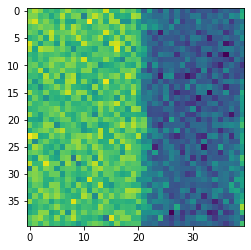

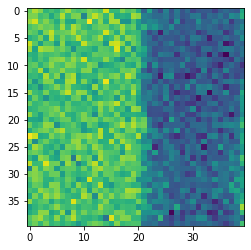

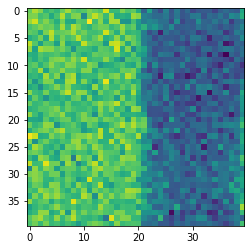

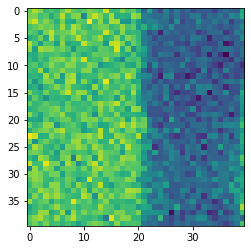

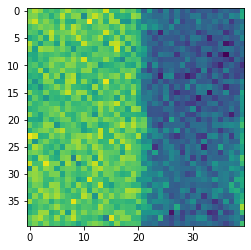

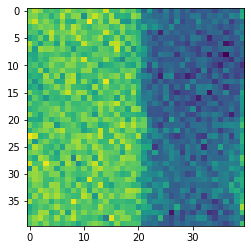

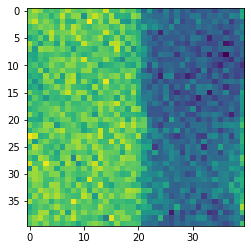

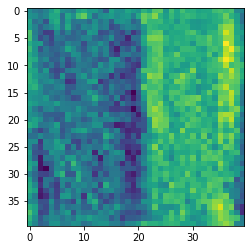

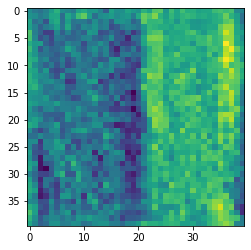

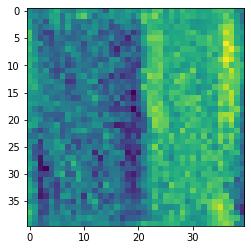

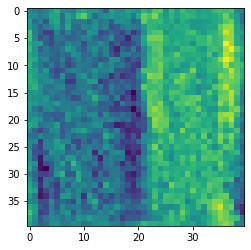

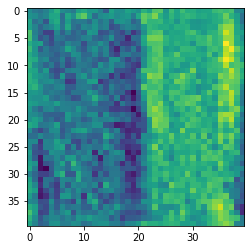

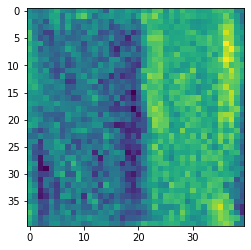

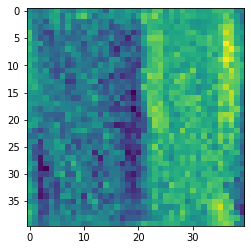

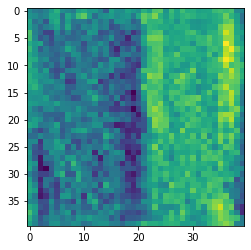

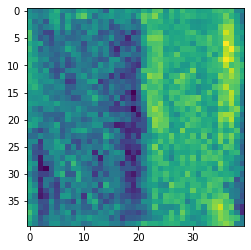

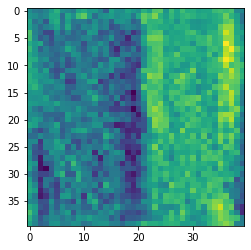

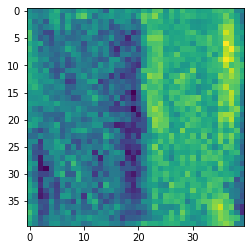

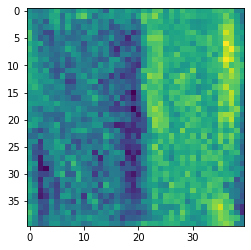

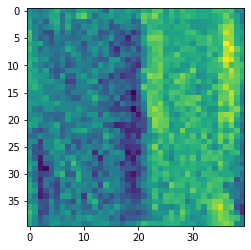

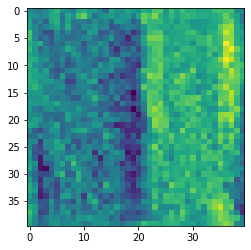

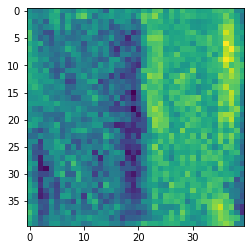

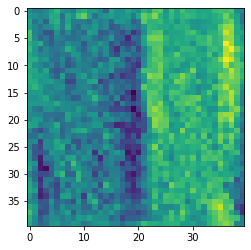

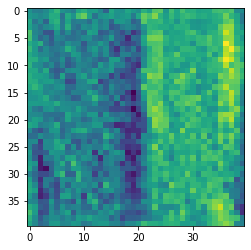

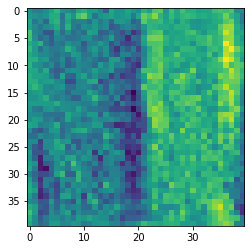

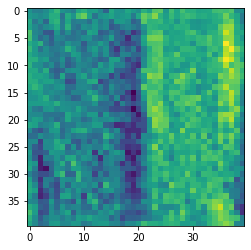

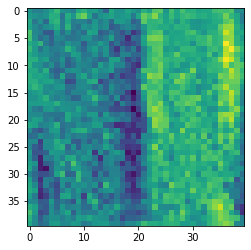

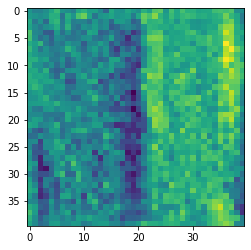

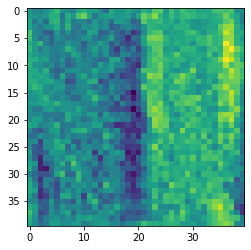

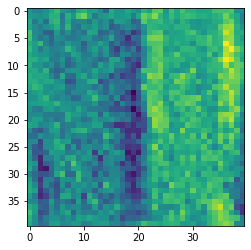

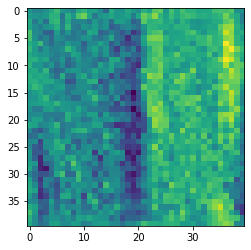

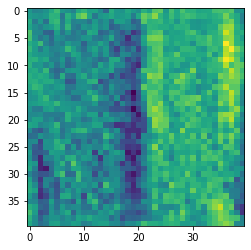

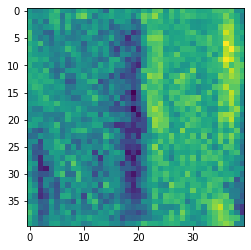

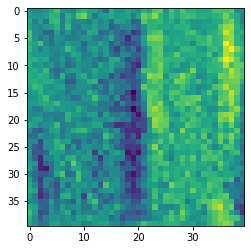

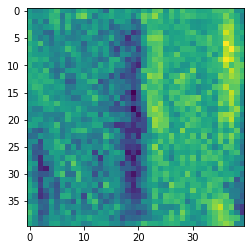

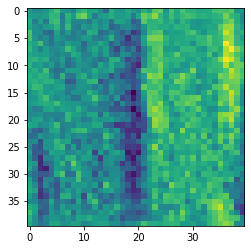

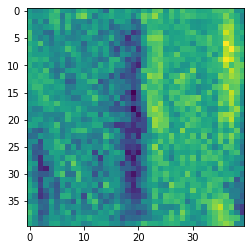

In [18]:
from matplotlib.pyplot import imshow, show

for image in results[5].image_history:
    imshow(image[0][0])
    show()

In [13]:
for param in results[5].net.parameters():
    print(param.shape)

NameError: name 'results' is not defined

In [1]:
import torch

In [4]:
# load image from computer
from PIL import Image
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow, show
import numpy as np

image = Image.open("/Users/laszlofreund/code/ai/hvae/eval_notebooks/kep.png")

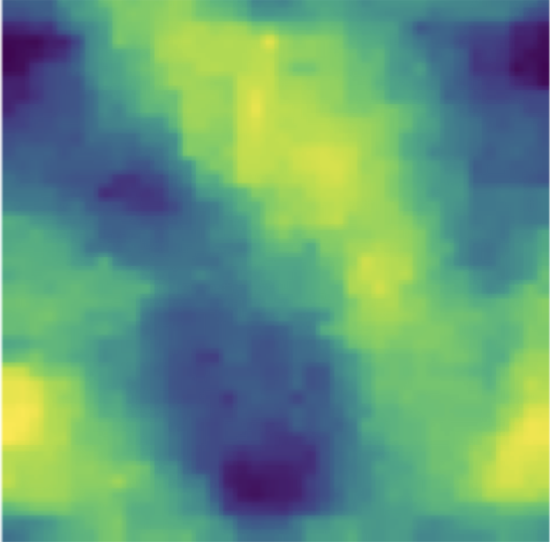

In [25]:
image

In [15]:
np.array(image)[..., 3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [35]:
f = torch.real(torch.fft.fft2(torch.tensor(np.array(image)), dim=(0, 1)))

In [36]:
f = f[..., 0:3]

In [37]:
f.shape

torch.Size([542, 554, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


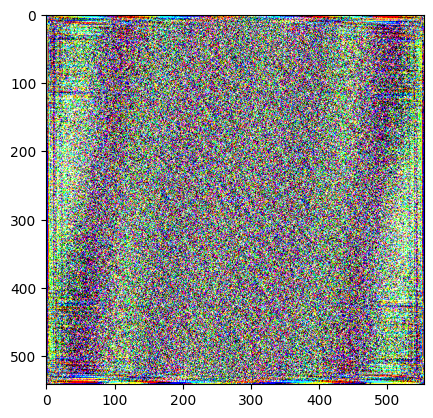

In [38]:
imshow(f)